In [188]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.




['fer2013', 'before-the-test']


In [189]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.layers import Dense, Convolution2D, UpSampling2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Reshape
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [190]:
import os
print(os.listdir("../input"))

['fer2013', 'before-the-test']


In [191]:
import csv
from matplotlib import pyplot as plt
import numpy as np

reshape_size = (48,48)
def GetData(filename):
    X = []
    Y = []
    with open(filename) as csv_file:
        f = 0
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if f == 0 :
                print(row)
                f = 1
            elif f == 1:
                pixels = np.fromstring(row[1], dtype=int, sep=' ')
                pixels = pixels.reshape( reshape_size )
                emotion = int(row[0])

                X.append(pixels)
                Y.append(emotion)
    return [X,Y]

In [192]:
[train_X, train_Y] = GetData('../input/before-the-test/train.csv')
train_X = np.array(train_X)
train_Y = np.array(train_Y)

print('Train data shape:',train_X.shape, train_Y.shape)

['emotion', 'pixels']
Train data shape: (28709, 48, 48) (28709,)


In [193]:
[validation_X, validation_Y] = GetData('../input/before-the-test/val.csv')
validation_X = np.array(validation_X)
validation_Y = np.array(validation_Y)

print('Validation data shape:',validation_X.shape, validation_Y.shape)

['emotion', 'pixels']
Validation data shape: (3589, 48, 48) (3589,)


In [194]:
[test_X, test_Y] = GetData('../input/before-the-test/test.csv')
test_X = np.array(test_X)
test_Y = np.array(test_Y)

print('Test data shape:',test_X.shape, test_Y.shape)

['emotion', 'pixels']
Test data shape: (3589, 48, 48) (3589,)


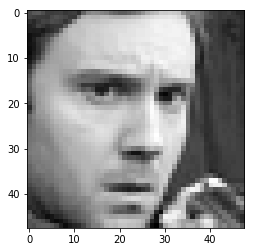

In [195]:
plt.figure(0)
plt.imshow(train_X[0], cmap = 'gray')
plt.show()

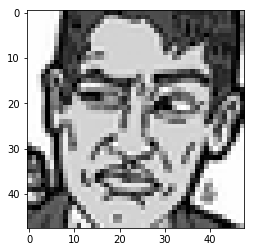

In [196]:
plt.figure(1)
plt.imshow(validation_X[0], cmap = 'gray')
plt.show()

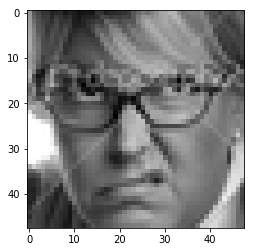

In [197]:
plt.figure(2)
plt.imshow(test_X[0], cmap = 'gray')
plt.show()

In [198]:
def ChangeTo4D(data):
    ip_shape = data.shape
    #ip_shape = ip_shape +(1,)
    #ip_shape = (1,)+ip_shape
    ip_shape = (ip_shape[0],1,ip_shape[1],ip_shape[2])
    return data.reshape(ip_shape)

In [199]:
train_X_4d = ChangeTo4D(train_X)
print(train_X_4d.shape)
validation_X_4d = ChangeTo4D(validation_X)
test_X_4d = ChangeTo4D(test_X)

(28709, 1, 48, 48)


In [200]:
train_X_4d = train_X_4d/255
validation_X_4d = validation_X_4d/255
test_X_4d = test_X_4d/255

In [201]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=True,  
        samplewise_center=False,  
        featurewise_std_normalization=True,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.0,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True, 
        vertical_flip=False)  

datagen.fit(train_X_4d)

In [202]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [203]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,48,48)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
# model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(512, activation=swish_activation))
# model.add(Dropout(0.4))
model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 32, 48, 48)        320       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 48, 48)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 64, 24, 24)        18496     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 64, 24, 24)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 12, 12)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 96, 12, 12)        55392     
__________

In [204]:
test_Y_one_hot_encoding = keras.utils.to_categorical(test_Y);
train_Y_one_hot_encoding = keras.utils.to_categorical(train_Y);
validation_Y_one_hot_encoding = keras.utils.to_categorical(validation_Y);

In [205]:
batch_size = 128
epochs = 14

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
#steps_per_epoch = len(train_X_4d) // batch_size
#validation_steps = len((validation_X_4d, validation_Y_one_hot_encoding)) // batch_size

In [206]:
history = model.fit_generator(datagen.flow(train_X_4d, train_Y_one_hot_encoding, batch_size=batch_size),
                    steps_per_epoch= train_X_4d.shape[0] // batch_size,
                    callbacks=[lr_reduce],
                    validation_data=(validation_X_4d, validation_Y_one_hot_encoding),
                    epochs = epochs, verbose = 2)

weights = model.get_weights()
np.save('my_model_weights', weights)

Epoch 1/14
 - 12s - loss: 0.4053 - acc: 0.8539 - val_loss: 0.3948 - val_acc: 0.8571
Epoch 2/14
 - 10s - loss: 0.3888 - acc: 0.8572 - val_loss: 0.3873 - val_acc: 0.8571

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/14
 - 10s - loss: 0.3772 - acc: 0.8579 - val_loss: 0.3958 - val_acc: 0.8571

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/14
 - 10s - loss: 0.3724 - acc: 0.8587 - val_loss: 0.3962 - val_acc: 0.8571

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 5/14
 - 12s - loss: 0.3714 - acc: 0.8589 - val_loss: 0.3961 - val_acc: 0.8571

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 6/14
 - 10s - loss: 0.3718 - acc: 0.8590 - val_loss: 0.3961 - val_acc: 0.8571

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 7/14
 - 10s - loss: 0.3720 - acc: 0.8590 - val_loss: 0.3961 - val_acc: 0.8571

Ep

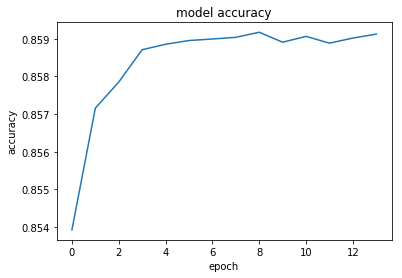

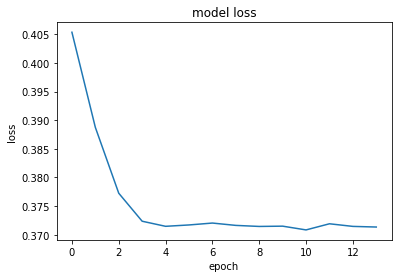

In [209]:
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [210]:
test_eval = model.evaluate(test_X_4d, test_Y_one_hot_encoding, verbose =1);
print('test loss and acc is', test_eval[0], test_eval[1]);

3589/3589 [==============================] - 1s 149us/step
test loss and acc is 0.39725088562497723 0.8571428655747685
